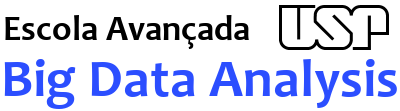

Generative Adversarial Networks - Fashion MNIST

In [ ]:
!pip uninstall tensorflow keras tensorstore tf-keras orbax-checkpoint -y
!pip install keras==2.15.0 tensorflow==2.15.0

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__) # Use __version__ to access version in TensorFlow 2.x and above

import keras
print("Keras version:", keras.__version__) # Use __version__ for Keras as well

import sys
print("Python version:", sys.version)

TensorFlow version: 2.8.1
Keras version: 2.8.0
Python version: 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]


In [ ]:
# Bibliotecas
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint

**Leaky ReLu**

Leaky Rectified Linear Unit, ou Leaky ReLU, é um tipo de função de ativação baseada em uma ReLU, mas tem uma pequena inclinação para valores negativos em vez de uma inclinação plana. O coeficiente de inclinação é determinado antes do treinamento, ou seja, não é aprendido durante o treinamento. Esse tipo de função de ativação é popular em tarefas nas quais podemos sofrer de gradientes esparsos, por exemplo, treinando redes adversárias generativas.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_3.09.45_PM.png" height=250 width=250>

**Conjunto de Dados MNIST**

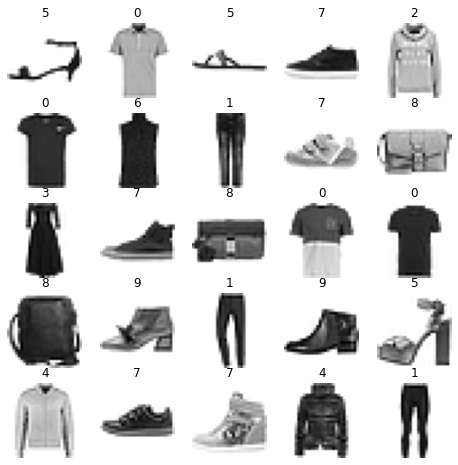

In [ ]:
# Conjunto de Dados Fashion MNIST
# Classes: 0 T-shirt/top; 1 Trouser; 2 Pullover; 3 Dress; 4 Coat; 5 Sandal; 6 Shirt; 7 Sneaker; 8 Bag; 9 Ankle boot

(trainX, trainy), (_, _) = fashion_mnist.load_data()

# plot 25 images
plt.figure(figsize=(8,8))
for i in range(25):
    idx = randint(trainX.shape[0])
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    #plt.imshow(trainX[idx],cmap=plt.get_cmap('gray'))
    plt.imshow(trainX[idx], cmap='binary')
    plt.title(str(trainy[idx]))
plt.show()

In [ ]:
trainX.shape

(60000, 28, 28)

In [ ]:
trainX[1]

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

In [ ]:
# Dimensões das imagens
img_rows = 28
img_cols = 28
canais = 1
img_shape = (img_rows,img_cols,canais)

In [ ]:
np.prod(img_shape)

784

In [ ]:
# Gerador
# Receber um vetor latente (ruído) e produzir uma imagem
def constroi_gerador():

  ruido_shape = (100,) # Array de tamanho 100

  # Camadas
  model = Sequential()
  model.add(Input(shape=ruido_shape))

  model.add(Dense(256, activation="LeakyReLU"))
  model.add(BatchNormalization())

  model.add(Dense(512, activation="LeakyReLU"))
  model.add(BatchNormalization())

  model.add(Dense(1024, activation="LeakyReLU"))
  model.add(BatchNormalization())

  # np.prod(img_shape) -> produtos dos valores em img_shape
  model.add(Dense(np.prod(img_shape), activation="LeakyReLU"))
  model.add(Reshape(img_shape)) # reshape para (28 x 28 x 1)

  model.summary()

  noise = Input(shape=ruido_shape)
  img = model(noise) # Imagem gerada

  return Model(noise,img)

In [ ]:
constroi_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4

2024-11-27 22:11:11.415756: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [ ]:
# Discriminador -> classificador binário.
# Pega uma imagem e classifica como verdadeira ou falsa.
def constroi_discriminador():

  model = Sequential()

  model.add(Input(shape=img_shape))

  model.add(Flatten())

  model.add(Dense(512, activation="LeakyReLU"))

  model.add(Dense(256, activation="LeakyReLU"))

  model.add(Dense(1, activation="sigmoid"))

  model.summary()

  img = Input(shape=img_shape)
  classe = model(img)

  return Model(img,classe)

In [ ]:
constroi_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilar o gerador e o discriminador

# Discriminador
discriminador = constroi_discriminador()
discriminador.compile(loss='binary_crossentropy',
                      optimizer="Adam",
                      metrics=['accuracy'])

# Gerador
gerador = constroi_gerador()
#gerador.compile(loss='binary_crossentropy',
#                optimizer="Adam")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               401920    
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)         

In [ ]:
# Treinamento
def treinamento(epocas, batch_size=128, save_interval=50):

  # Carregar e processar os dados
  # ----------------------------------------
  (X_train, _), (_, _) = fashion_mnist.load_data()

  # Converter para (-1,1)
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5

  # Adicionar a profundidade (1 canal)
  X_train = np.expand_dims(X_train, axis=3)

  # Metade de um batch
  meio_batch = int(batch_size / 2)
  # ----------------------------------------

  # Para cada época
  for epoca in range(epocas):

    # Pega os dados e treina o discriminador
    # Metade real e metade falso

    # ----------------------
    # Treina o discriminador
    # ----------------------

    # Pega imagens reais aleatoriamente
    idx = np.random.randint(0, X_train.shape[0], meio_batch)
    imgs = X_train[idx]

    # Gera ruído
    ruido = np.random.normal(0,1,(meio_batch,100))

    # Gera imagens falsas
    gen_imgs = gerador.predict(ruido)

    # Treina o discriminador nas imagens reais e falsas
    d_erro_real = discriminador.train_on_batch(imgs, np.ones((meio_batch,1)),return_dict=True)
    d_erro_fake = discriminador.train_on_batch(gen_imgs,np.zeros((meio_batch,1)),return_dict=True)

    # Média do erro real e verdadeiro
    d_erro = 0.5 * np.add(d_erro_real['loss'],d_erro_fake['loss'])

    # ----------------------
    # Treina o gerador
    # ----------------------

    # Cria um batch de ruido
    ruido = np.random.normal(0,1,(batch_size,100))

    # O gerador quer enganar o discriminador
    classe_g = np.array([1] * batch_size)

    # Construir um modelo combinado do gerador e do discriminador
    g_erro = combinado.train_on_batch(ruido,classe_g,return_dict=True)

    # Imprimir erros
    print ("Época: %d [D Loss: %f] [G Loss: %f]" % (epoca, d_erro, g_erro['loss']))

    # Salvar imagens geradas
    if epoca % save_interval == 0:
      save_imgs(epoca)


In [ ]:
# Combinando o gerador e o discriminador
z = Input(shape=(100,))
img = gerador(z)

# Como eu quero treinar o gerador no modelo combinado,
# precisamos congelar os pesos do discriminador
discriminador.trainable = False

# Saída do discriminador
saida_d = discriminador(img)

# Modelo combinado (gerador + discriminador)
combinado = Model(z,saida_d)
combinado.compile(loss="binary_crossentropy", optimizer="Adam")

combinado.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_3 (Functional)        (None, 28, 28, 1)         1493520   
                                                                 
 model_2 (Functional)        (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [ ]:
# Função para salvar imagens
def save_imgs(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r * c, 100))
  gen_imgs = gerador.predict(noise)

  # Redimensiona imagens 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='binary')
      axs[i,j].axis('off')
      cnt += 1
  fig.savefig("images_fmnist/fmnist_%d.png" % epoch)
  plt.close()

In [ ]:
!mkdir /content/images_fmnist/
treinamento(1000000, batch_size=128, save_interval=100)

Época: 0 [D Loss: 0.481079] [G Loss: 4.093750]
Época: 1 [D Loss: 0.102070] [G Loss: 6.785156]
Época: 2 [D Loss: 0.046129] [G Loss: 8.554688]
Época: 3 [D Loss: 0.017057] [G Loss: 10.242188]
Época: 4 [D Loss: 0.008668] [G Loss: 11.179688]
Época: 5 [D Loss: 0.004204] [G Loss: 11.640625]
Época: 6 [D Loss: 0.023317] [G Loss: 10.007812]
Época: 7 [D Loss: 0.004501] [G Loss: 7.761719]
Época: 8 [D Loss: 0.037170] [G Loss: 4.664062]
Época: 9 [D Loss: 0.028320] [G Loss: 2.757812]
Época: 10 [D Loss: 0.135498] [G Loss: 1.666016]
Época: 11 [D Loss: 0.227905] [G Loss: 2.628906]
Época: 12 [D Loss: 0.208130] [G Loss: 4.117188]
Época: 13 [D Loss: 0.131118] [G Loss: 7.210938]
Época: 14 [D Loss: 0.060760] [G Loss: 11.953125]
Época: 15 [D Loss: 0.033361] [G Loss: 17.796875]
Época: 16 [D Loss: 0.017960] [G Loss: 22.343750]
Época: 17 [D Loss: 0.124050] [G Loss: 24.203125]
Época: 18 [D Loss: 0.167786] [G Loss: 22.500000]
Época: 19 [D Loss: 0.070953] [G Loss: 20.203125]
Época: 20 [D Loss: 0.022601] [G Loss: 18